Import all important libraries:

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [30]:
import keras
print(keras.__version__)

3.0.0


In [116]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas

### Transform object-detection dataset to image classification dataset (helper functions)

Load Kitti dataset

In [ ]:

# import tensorflow_datasets as tfds
# (training_set, test_set, validation_set), dataset_info = tfds.load('kitti',
#                                                          split=['train[:80%]', 'train[80:90%]', 'train[90%:]'],
#                                                         #  download=True,
#                                                          with_info=True,
#                                                          )
# print(f"Number of training samples: {training_set.cardinality()}")
# print(f"Number of validation samples: {validation_set.cardinality()}")
# print(f"Number of test samples: {test_set.cardinality()}")
# (test_set, validation_set), dataset_info = tfds.load('kitti',
#             split=['test', 'validation'],
#         #  download=True,
#         with_info=True,
#             )

 and transform into train, test and validation datasets with corect box coordinates. All images will be saved in corresponding folders.

In [ ]:
def cut_image(image, box):
        h,w,ch = image.shape
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
        object = image[ymax:ymin, xmin:xmax, :]
        
        if object.shape[1]==0 or object.shape[0]==0:                
            print("error with image shape")
        return object

def transform_dataset(ds, ds_path, ds_name, ds_type, info):

    # create ds directory if not exists
    save_path = os.path.join(ds_path, ds_name, ds_type)
    os.makedirs(save_path, exist_ok=True)
    # create classes folders if not exist
    names = np.asarray(info.features["objects"]["type"].names)
    for name in names:
        os.makedirs(os.path.join(save_path, name), exist_ok=True)
    
    for el in ds:
        image = el["image"].numpy()
        image_name = bytes.decode(el["image/file_name"].numpy())
        boxes = el["objects"]["bbox"]
        classes = el["objects"]["type"]
        for i, (box, label) in enumerate(zip(boxes, classes)):
            file_name = os.path.join(save_path, names[label], str(i)+image_name)
            cv2.imwrite(file_name, cut_image(image, box))

In [ ]:
# uncomment to transform datasets
path = os.path.join(os.getcwd(), "dataset")   
# transform_dataset(training_set.skip(0).take(1000), path, 'kitti', 'train', dataset_info)
# transform_dataset(test_set.skip(0).take(1000), path, 'kitti', 'test', dataset_info)

Now these images can be loaded as Dataset.

In [32]:
IMAGE_RES = 150
BATCH_SIZE = 64

train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/train/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES),
    validation_split=0.2,
    seed=121,
    subset="both"
)

Found 14136 files belonging to 8 classes.
Using 11309 files for training.
Using 2827 files for validation.


In [33]:
test_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/test/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES)
)

Found 3958 files belonging to 8 classes.


There are 8 object classes in Kitti dataset:

In [34]:
class_names = np.asarray(train_ds.class_names)
NUM_CLASSES = len(class_names)

In [35]:
print(train_ds.class_names)

['Car', 'Cyclist', 'Misc', 'Pedestrian', 'Person_sitting', 'Tram', 'Truck', 'Van']


Here is a class distribution. I have lessened number of cars, it was drastically larger.

<BarContainer object of 8 artists>

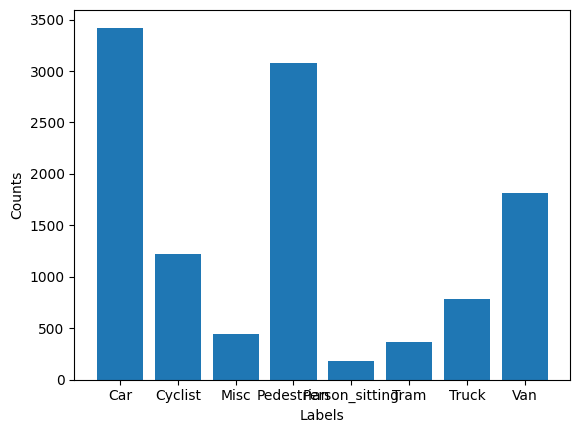

In [112]:
labels = list(train_ds.unbatch().map(lambda x,y: y).as_numpy_iterator())
# print(labels)
classes, counts = np.unique(labels, return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.bar(class_names[classes], counts) 

Plot images with class names

In [110]:
def plot_batch(ds, class_names, num, predict=False, model=None):

    plt.figure(figsize=(10, 10))
    image_batch, label_batch = next(iter(ds.take(1)))
    image_batch = image_batch.numpy().astype(int)
    label_batch = label_batch.numpy()

    if predict:
        predicted_batch = model.predict(image_batch)
        predicted_ids = np.argmax(predicted_batch, axis=1)
        
    for i in range(num):
        ax = plt.subplot(int(np.sqrt(num)), int(np.sqrt(num)), i + 1)
        plt.imshow(image_batch[i])

        if predict:
            color = "blue" if predicted_ids[i] == label_batch[i] else "red"
            plt.title(class_names[predicted_ids[i]] + '('+class_names[label_batch[i]]+')', color=color)
        else:
            plt.title(class_names[label_batch[i]], color="blue")
        plt.axis("off")

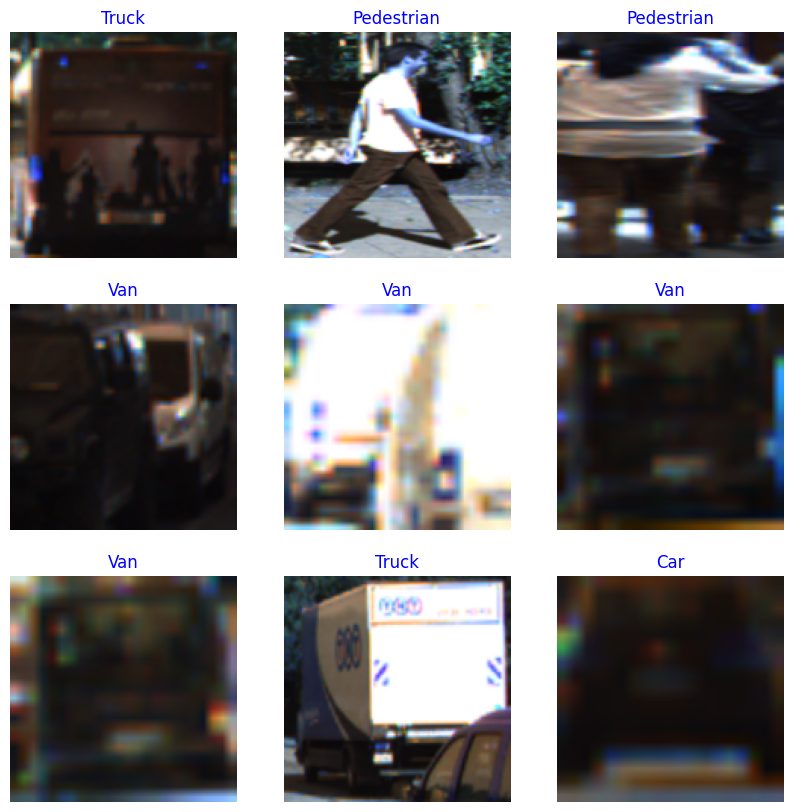

In [113]:
plot_batch(train_ds,class_names,9)

Add data augmentation, so a classifier is robust to changes in object orientation.

In [38]:
augmenter = keras.Sequential(
    [
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomTranslation(0.1,0.1),
        keras.layers.RandomZoom(0.1,0.1)
    ],
)

def preprocess_data(images, labels, augment=False):
    if augment:
        images = augmenter(images)
    return images, labels

Augment train dataset and prefetch all datasets

In [39]:
train_batched_dataset = train_ds.map(lambda x, y: preprocess_data(x, y, augment=True)).prefetch(1)

In [40]:
valid_batched_dataset = valid_ds.prefetch(1)

In [41]:
test_batches = test_ds.prefetch(1)

Plot images with augmentation

2024-04-12 16:15:00.741555: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2142831885939602968
2024-04-12 16:15:00.741655: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 967523375667394380
2024-04-12 16:15:00.741661: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14201979492995550287
2024-04-12 16:15:00.741709: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9955363061414775552
2024-04-12 16:15:00.741731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8079493150348066004
2024-04-12 16:15:00.741737: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10324340838832135276
2024-04-12 16:15:00.741759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

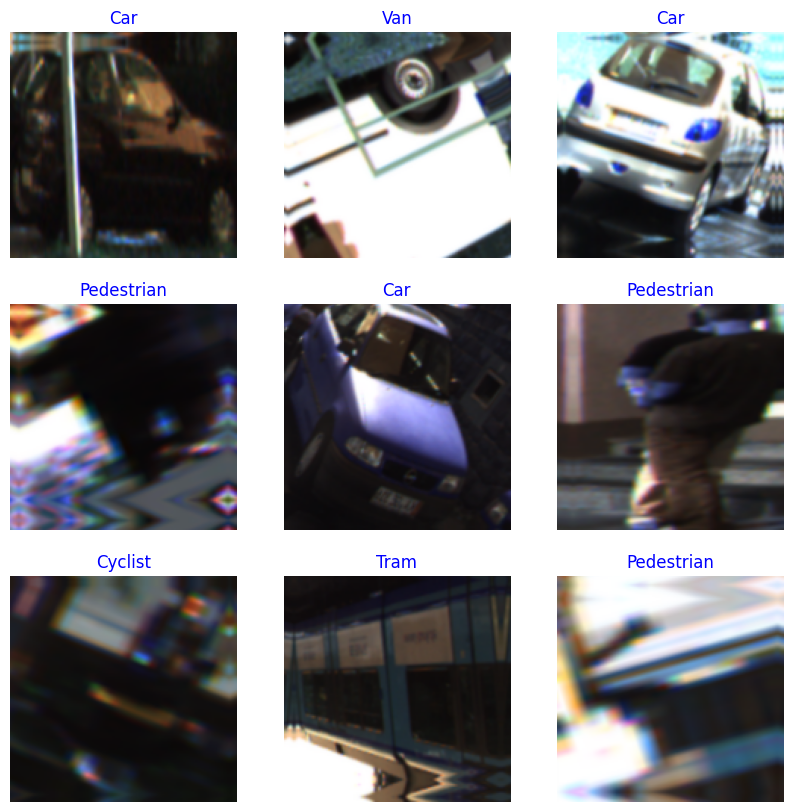

In [114]:
plot_batch(train_batched_dataset,class_names,9)

Create a nn model with Xception as feature vector.

In [44]:
def create_base_model(input_shape: tuple[int, int, int] = (IMAGE_RES, IMAGE_RES, 3),
                      output_shape: int = NUM_CLASSES,
                      learning_rate: float = 0.001,
                      training: bool = False) -> keras.Model:
    
    base_model = keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=input_shape,
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = training

    # Create new model on top
    inputs = keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

    # Pre-trained MobileNetV2 weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    # or map dataset with this function:
    # def preprocess(images, labels):
    #   return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(output_shape, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.summary(show_trainable=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [56]:
model = create_base_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)       │ 20,861… │   N   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense_1 (Dense)             │ (None, 8)                │  16,392 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 20,877,872 (79.64 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Create custom callbacks for data save

In [74]:
checkpoint_path = ".checkpoints/checkpoint.weights.h5"
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.CSVLogger('./logs/fine-tuning.log', append=True),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True, # set to False to save the entire model
                                    save_best_only=True, # save only the best model weights instead of a model every epoch
                                    save_freq="epoch", # save every epoch
                                    verbose=1)
]

Initial fit of data

In [57]:
initial_epochs = 5

history = model.fit(train_batched_dataset, 
                    epochs=initial_epochs, 
                    validation_data=valid_batched_dataset, 
                    callbacks=my_callbacks)

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 1.3221 - sparse_categorical_accuracy: 0.5315
Epoch 1: val_loss did not improve from 0.49877
177/177 ━━━━━━━━━━━━━━━━━━━━ 73s 383ms/step - loss: 1.3209 - sparse_categorical_accuracy: 0.5319 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7276
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.8616 - sparse_categorical_accuracy: 0.7076
Epoch 2: val_loss did not improve from 0.49877
177/177 ━━━━━━━━━━━━━━━━━━━━ 73s 412ms/step - loss: 0.8616 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7443
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.8037 - sparse_categorical_accuracy: 0.7172
Epoch 3: val_loss did not improve from 0.49877
177/177 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - loss: 0.8036 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.7722
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 0.7550

In [58]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.6283


[1.0902085304260254, 0.6384537816047668]

In [ ]:
# model.save(os.path.join(os.getcwd(), "models", "model_kitti_sgd_55ep.keras"))

Plot history of the model training

In [80]:
def plot_hist(hist, initial_epochs):
    acc = hist['sparse_categorical_accuracy']
    val_acc = hist['val_sparse_categorical_accuracy']

    loss = hist['loss']
    val_loss = hist['val_loss']

    epochs_range = range(len(hist['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if initial_epochs:        
        plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if initial_epochs:        
        plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

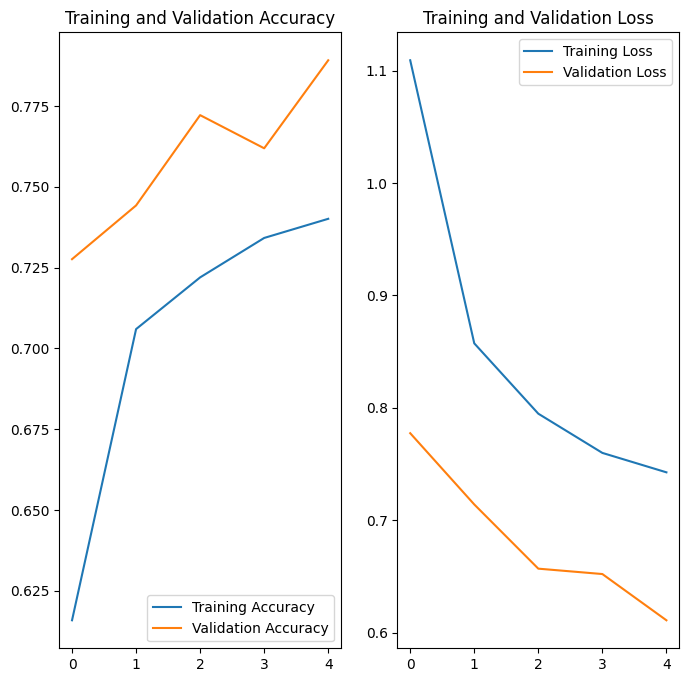

In [59]:
plot_hist(history.history)

Unfreeze 10 last layers of Xception model and set optimizer learning rate smaller.

In [64]:
model_base_model = model.layers[2]
model_base_model.name
model_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_base_model.layers[:-10]:
  layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), # smaller learning rate
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],)

In [65]:
print(len(model.trainable_variables))

13


Fit model for additional epochs

In [66]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine = model.fit(train_batched_dataset, 
                        epochs=fine_tune_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=valid_batched_dataset, 
                        callbacks=my_callbacks)

Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.8667 - sparse_categorical_accuracy: 0.7244
Epoch 5: val_loss did not improve from 0.49877
177/177 ━━━━━━━━━━━━━━━━━━━━ 94s 440ms/step - loss: 0.8662 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0100 - val_sparse_categorical_accuracy: 0.6668
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7995
Epoch 6: val_loss did not improve from 0.49877
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 437ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.5568 - val_sparse_categorical_accuracy: 0.8139
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.5199 - sparse_categorical_accuracy: 0.8175
Epoch 7: val_loss improved from 0.49877 to 0.44466, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 93s 520ms/step - loss: 0.5198 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.4447 - val_sparse_categorical_accuracy: 0.8465
Epoch 8/

In [67]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 1.3412 - sparse_categorical_accuracy: 0.6172


[1.2891035079956055, 0.6245578527450562]

In [71]:
def plot_fine_tuned_hist(hist_old, hist_new, initial_epochs=5):
    acc = hist_old['sparse_categorical_accuracy'] + hist_new['sparse_categorical_accuracy']
    val_acc = hist_old['val_sparse_categorical_accuracy'] + hist_new['val_sparse_categorical_accuracy']

    loss = hist_old['loss'] + hist_new['loss']
    val_loss = hist_old['val_loss'] + hist_new['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

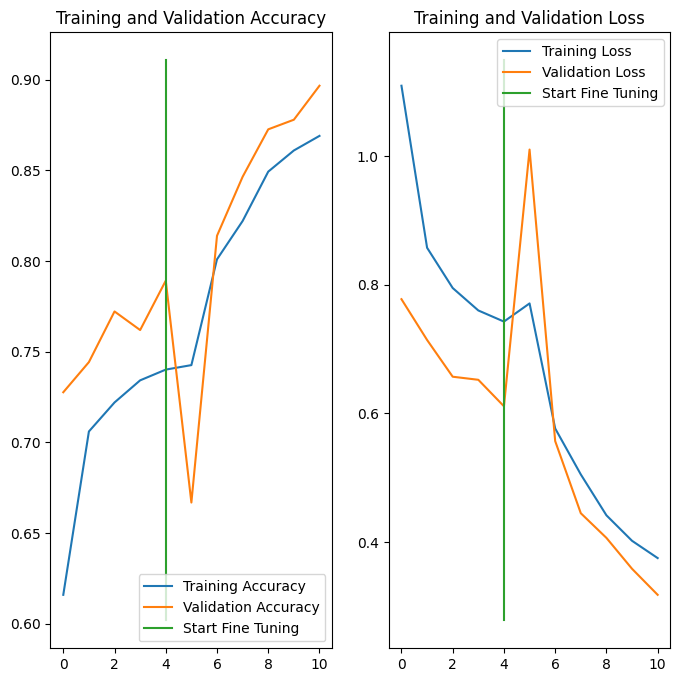

In [72]:
plot_fine_tuned_hist(history.history, history_fine.history, initial_epochs)

In [78]:
# Fine tune for another 5 epochs
fine_tune_epochs = fine_tune_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine2 = model.fit(train_batched_dataset, 
                        epochs=fine_tune_epochs,
                        initial_epoch=history_fine.epoch[-1],
                        validation_data=valid_batched_dataset, 
                        callbacks=my_callbacks)

Epoch 10/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.3315 - sparse_categorical_accuracy: 0.8915
Epoch 10: val_loss improved from inf to 0.33067, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 69s 383ms/step - loss: 0.3315 - sparse_categorical_accuracy: 0.8915 - val_loss: 0.3307 - val_sparse_categorical_accuracy: 0.8978
Epoch 11/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.8928
Epoch 11: val_loss improved from 0.33067 to 0.29984, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - loss: 0.3018 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2998 - val_sparse_categorical_accuracy: 0.9091
Epoch 12/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9004
Epoch 12: val_loss improved from 0.29984 to 0.27936, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 90s 503ms/step - loss: 

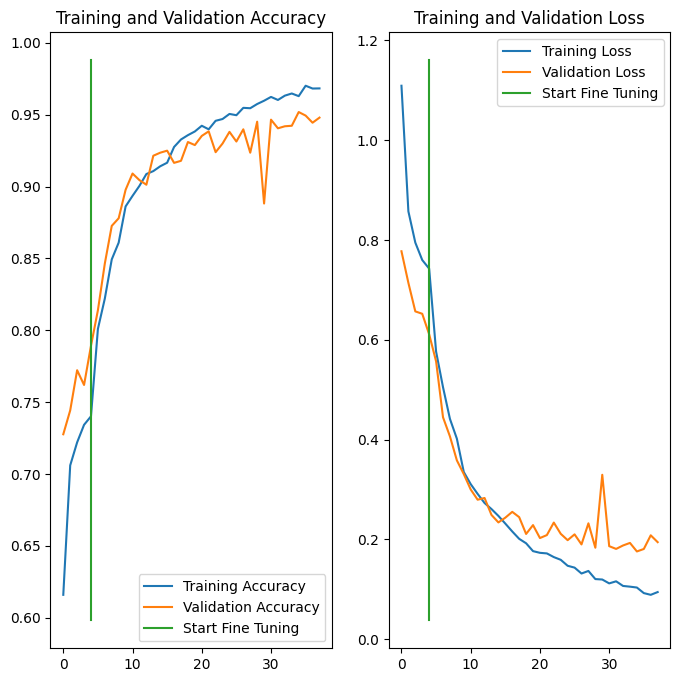

In [115]:
df = pandas.read_csv('./logs/fine-tuning.log')
plot_hist(df,5)

In [82]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 1.4501 - sparse_categorical_accuracy: 0.6237


[1.4167828559875488, 0.6321374177932739]

In [83]:
# Fine tune for another 5 epochs
fine_tune_epochs = fine_tune_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine3 = model.fit(train_batched_dataset, 
                        epochs=fine_tune_epochs,
                        initial_epoch=history_fine.epoch[-1],
                        validation_data=valid_batched_dataset, 
                        callbacks=my_callbacks)

Epoch 10/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9231
Epoch 10: val_loss did not improve from 0.23381
177/177 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.2434 - val_sparse_categorical_accuracy: 0.9250
Epoch 11/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9293
Epoch 11: val_loss did not improve from 0.23381
177/177 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9293 - val_loss: 0.2550 - val_sparse_categorical_accuracy: 0.9165
Epoch 12/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9345
Epoch 12: val_loss did not improve from 0.23381
177/177 ━━━━━━━━━━━━━━━━━━━━ 89s 501ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.2444 - val_sparse_categorical_accuracy: 0.9179
Epoch 13/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - l

Plot history from saved csv.

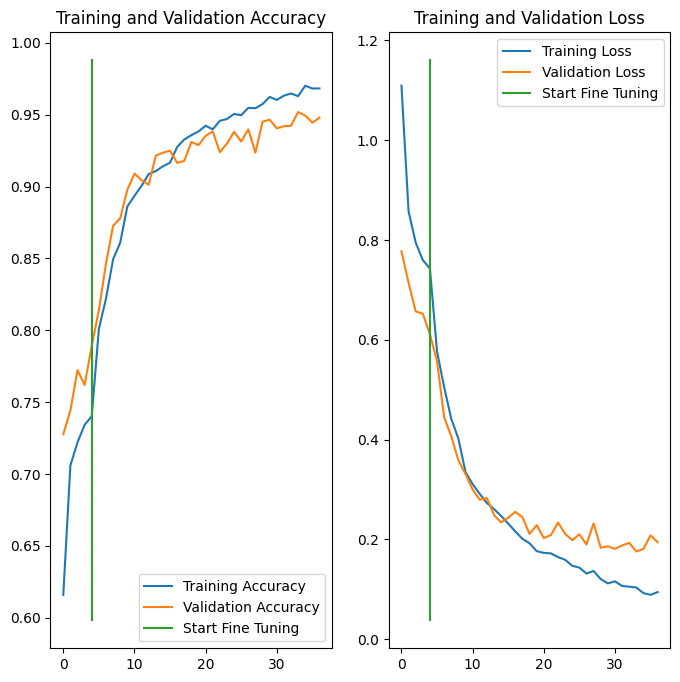

In [118]:
df = pandas.read_csv('./logs/fine-tuning.log')
plot_hist(df,5)

In [86]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 1.3068 - sparse_categorical_accuracy: 0.6844


[1.2753095626831055, 0.6910055875778198]

In [87]:
# additional model save
# model.save(os.path.join(os.getcwd(), "models", "model_kitti_xception_adam_25ep.keras"))
# model.save_weights(os.path.join(os.getcwd(), ".checkpoints", "model_kitti_xception_adam_25ep.weights.h5"))

In [88]:
# Fine tune for another 5 epochs
fine_tune_epochs = fine_tune_epochs + 5

history_fine4 = model.fit(train_batched_dataset, 
                        epochs=fine_tune_epochs,
                        initial_epoch=history_fine3.epoch[-1],
                        validation_data=valid_batched_dataset, 
                        callbacks=my_callbacks)

Epoch 20/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9545
Epoch 20: val_loss improved from 0.19823 to 0.18973, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.1897 - val_sparse_categorical_accuracy: 0.9399
Epoch 21/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9578
Epoch 21: val_loss did not improve from 0.18973
177/177 ━━━━━━━━━━━━━━━━━━━━ 76s 428ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9578 - val_loss: 0.2320 - val_sparse_categorical_accuracy: 0.9236
Epoch 22/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9606
Epoch 22: val_loss improved from 0.18973 to 0.18308, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 87s 491ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9606 - val_l

In [89]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - loss: 1.4962 - sparse_categorical_accuracy: 0.6660


[1.4640722274780273, 0.6819100379943848]

In [91]:
fine_tune_epochs = fine_tune_epochs + 5

history_fine5 = model.fit(train_batched_dataset, 
                        epochs=fine_tune_epochs,
                        initial_epoch=history_fine4.epoch[-1],
                        validation_data=valid_batched_dataset, 
                        callbacks=my_callbacks)

Epoch 25/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.9663
Epoch 25: val_loss did not improve from 0.18071
177/177 ━━━━━━━━━━━━━━━━━━━━ 69s 384ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1876 - val_sparse_categorical_accuracy: 0.9420
Epoch 26/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.9645
Epoch 26: val_loss did not improve from 0.18071
177/177 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.1927 - val_sparse_categorical_accuracy: 0.9423
Epoch 27/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9640
Epoch 27: val_loss improved from 0.18071 to 0.17563, saving model to .checkpoints/checkpoint.weights.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 90s 506ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.1756 - val_sparse_categorical_accuracy: 0.9519
Ep

In [93]:
model_ev = model.evaluate(test_batches)
model_ev

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 1.5356 - sparse_categorical_accuracy: 0.6793


[1.4831812381744385, 0.6940373778343201]

Load model with the best results from checkpoint and evaluate it.

In [94]:
model_2 = create_base_model(learning_rate=0.0001)
model_2.load_weights(checkpoint_path)
model2_ev = model_2.evaluate(test_batches)
model2_ev

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_9 (InputLayer)  │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling_3 (Rescaling)     │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)       │ 20,861… │   N   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d_3  │ (None, 2048)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 2048)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense_3 (Dense)             │ (None, 8)                │  16,392 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 20,877,872 (79.64 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

/mnt/c/projects/scene_perception/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:355: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - loss: 1.3636 - sparse_categorical_accuracy: 0.6850


[1.3333147764205933, 0.694290041923523]

Plot final predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


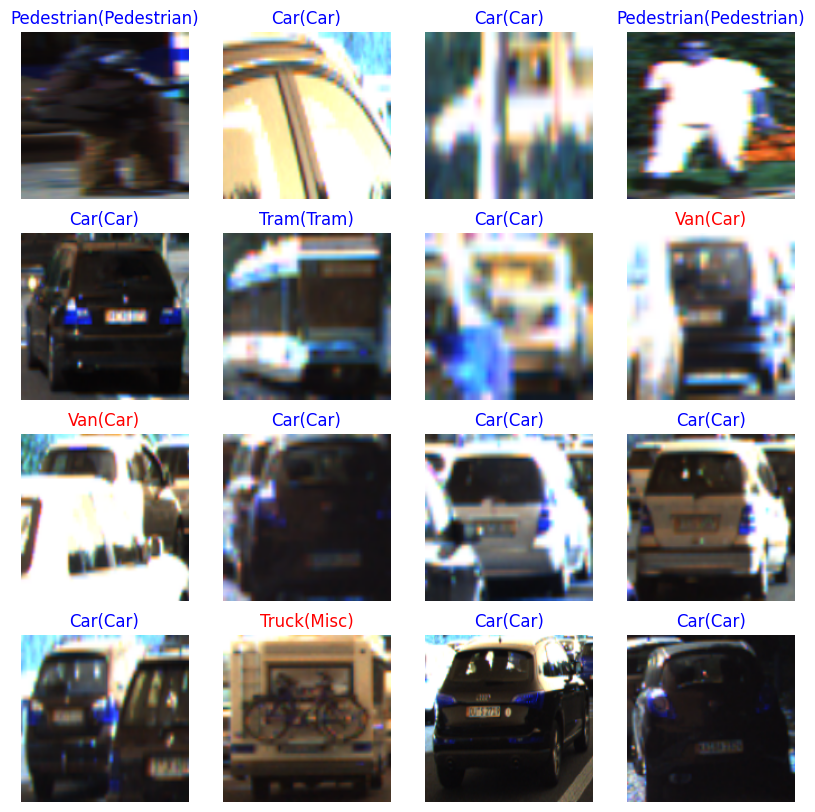

In [109]:
plot_batch(test_batches, class_names, 16, True, model_2, )